# Installing needed libraries and frameworks

In [1]:
!pip install gym_super_mario_bros==7.3.0 nes_py
!pip install torch==1.10.1+cu113 torchvision==0.11.2+cu113 torchaudio===0.10.1+cu113 -f https://download.pytorch.org/whl/cu113/torch_stable.html
!pip install stable-baselines3[extra]

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 198 kB 16.4 MB/s 
     |████████████████████████████████| 77 kB 6.1 MB/s 
     |████████████████████████████████| 1.1 MB 54.2 MB/s 
  Created wheel for nes-py: filename=nes_py-8.2.1-cp37-cp37m-linux_x86_64.whl size=435610 sha256=1e8e478eb39db6e3bdaeb8d93bbbfc919ff384f0dd88743f0876d5b4c284e1ad
  Stored in directory: /root/.cache/pip/wheels/17/96/0e/22a8c7dbdf412d8e988286f223b223baf0f4ad90c9e699c56d
Successfully built nes-py
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://download.pytorch.org/whl/cu113/torch_stable.html
     |██████████████▋                 | 834.1 MB 1.3 MB/s eta 0:12:41tcmalloc: large alloc 1147494400 bytes == 0x3a126000 @  0x7fec8b159615 0x58ead6 0x4f355e 0x4d222f 0x51041f 0x5b4ee6 0x58ff2e 0x510325 0x5b4ee6 0x58ff2e 0x50d482 0x4d00fb 0x50cb8d 0x4d00fb 0x5

# Import the game

In [2]:
import gym_super_mario_bros
# Import the Joypad wrapper
from nes_py.wrappers import JoypadSpace
# Import the SIMPLIFIED controls
from gym_super_mario_bros.actions import SIMPLE_MOVEMENT

In [3]:
# Setup game
env = gym_super_mario_bros.make('SuperMarioBros-v0')
env = JoypadSpace(env, SIMPLE_MOVEMENT)

In [4]:
# Import Frame Stacker Wrapper and GrayScaling Wrapper
from gym.wrappers import GrayScaleObservation
# Import Vectorization Wrappers
from stable_baselines3.common.vec_env import VecFrameStack, DummyVecEnv
# Import Matplotlib to show the impact of frame stacking
from matplotlib import pyplot as plt

# Create the base environment

In [5]:
env = gym_super_mario_bros.make('SuperMarioBros-v3')
#Simplify the controls 
env = JoypadSpace(env, SIMPLE_MOVEMENT)
#Grayscale
env = GrayScaleObservation(env, keep_dim=True)
#Wrap inside the Dummy Environment
env = DummyVecEnv([lambda: env])
#Stack the frames
env = VecFrameStack(env, 4, channels_order='last')

In [6]:
state = env.reset()

In [7]:
state, reward, done, info = env.step([5])

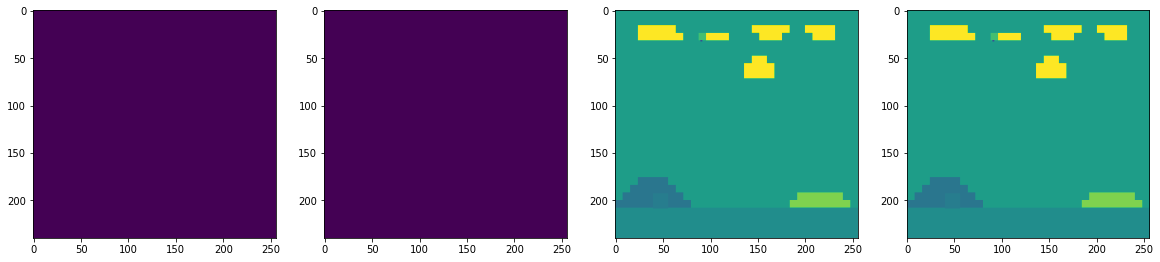

In [8]:
plt.figure(figsize=(20,16))
for idx in range(state.shape[3]):
    plt.subplot(1,4,idx+1)
    plt.imshow(state[0][:,:,idx])
plt.show()

# Baseline directory management

In [9]:
# Import os for file path management
import os 
# Import PPO for algos
from stable_baselines3 import PPO
# Import Base Callback for saving models
from stable_baselines3.common.callbacks import BaseCallback

In [10]:
class TrainAndLoggingCallback(BaseCallback):

    def __init__(self, check_freq, save_path, verbose=1):
        super(TrainAndLoggingCallback, self).__init__(verbose)
        self.check_freq = check_freq
        self.save_path = save_path

    def _init_callback(self):
        if self.save_path is not None:
            os.makedirs(self.save_path, exist_ok=True)

    def _on_step(self):
        if self.n_calls % self.check_freq == 0:
            model_path = os.path.join(self.save_path, 'best_model_{}'.format(self.n_calls))
            self.model.save(model_path)

        return True

In [11]:
CHECKPOINT_DIR = './train/'
LOG_DIR = './logs/'

In [12]:
# model logs callbacks
callback = TrainAndLoggingCallback(check_freq=10000, save_path=CHECKPOINT_DIR)

# Training model

In [13]:
model = PPO('CnnPolicy', env, verbose=1, tensorboard_log=LOG_DIR, learning_rate=0.000001, 
            n_steps=512) 

Using cuda device
Wrapping the env in a VecTransposeImage.


# Model training

In [14]:
model.learn(total_timesteps=500000, callback=callback)

Logging to ./logs/PPO_1


/usr/local/lib/python3.7/dist-packages/gym_super_mario_bros/smb_env.py:148: RuntimeWarning: overflow encountered in ubyte_scalars
  return (self.ram[0x86] - self.ram[0x071c]) % 256


Streaming output truncated to the last 5000 lines.
|    time_elapsed         | 5413          |
|    total_timesteps      | 358400        |
| train/                  |               |
|    approx_kl            | 0.00049770554 |
|    clip_fraction        | 0.000977      |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.224        |
|    explained_variance   | 0.547         |
|    learning_rate        | 1e-06         |
|    loss                 | 127           |
|    n_updates            | 6990          |
|    policy_gradient_loss | -0.000189     |
|    value_loss           | 508           |
-------------------------------------------
-------------------------------------------
| time/                   |               |
|    fps                  | 66            |
|    iterations           | 701           |
|    time_elapsed         | 5420          |
|    total_timesteps      | 358912        |
| train/                  |               |
|    approx_kl           

# Trained Model

In [15]:
model.save('learningstates')

In [16]:
# Load model
model = PPO.load('./train/best_model_500000')

In [17]:
state = env.reset()

# Running game with max iterations of 500 thousand

In [26]:
#run the game 
import gym
from gym import wrappers

env = gym_super_mario_bros.make('SuperMarioBros-v0')
env = wrappers.Monitor(env, "./gym-results", force=True)
env.reset()
for _ in range(3600):
    action = env.action_space.sample()
    observation, reward, done, info = env.step(action)
    if done: break
env.close()

/usr/local/lib/python3.7/dist-packages/gym_super_mario_bros/smb_env.py:148: RuntimeWarning: overflow encountered in ubyte_scalars
  return (self.ram[0x86] - self.ram[0x071c]) % 256


# Saving 1 minute video

In [27]:
import io
import base64
from IPython.display import HTML

video = io.open('./gym-results/openaigym.video.%s.video000000.mp4' % env.file_infix, 'r+b').read()
encoded = base64.b64encode(video)
HTML(data='''
    <video width="360" height="auto" alt="test" controls><source src="data:video/mp4;base64,{0}" type="video/mp4" /></video>'''
.format(encoded.decode('ascii')))

# References: 

https://www.youtube.com/watch?v=Mut_u40Sqz4&t=1907s




https://www.youtube.com/watch?v=2eeYqJ0uBKE